In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random
import sympy


Bad key "text.kerning_factor" on line 4 in
/home/sc/anaconda3/envs/old_nx/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
max_B = 10000 # maximum budget
no_runs = 100 # no. of runs to average
K = 4 # controls number of restarts

np.random.seed(0)
random.seed(42)

In [3]:
edges = np.loadtxt('facebook_combined.txt',dtype=int)

G = nx.Graph()
G.add_edges_from(edges)

G_no_edges=G.number_of_edges()
G_no_nodes=G.number_of_nodes()
print(G_no_nodes,G_no_edges)

4039 88234


In [4]:
from louvain import detect_communities, modularity
'''
def draw_communities(G, node_size=90, alpha=1, k=None, randomized=False):
    partition = detect_communities(G, randomized=randomized)
    print("Modularity for best partition:", modularity(G, partition))
    community_map = {}
    for community, nodes in enumerate(partition):
        for node in nodes:
            community_map[node] = community
    
    cmap = plt.get_cmap("jet")
    plt.figure(figsize=(15, 15))
    pos = nx.spring_layout(G, k=k)
    indexed = [community_map.get(node) for node in G]
    plt.axis("off")
    nx.draw_networkx_nodes(G, pos=pos, cmap=cmap, node_color=indexed, node_size=node_size, alpha=alpha)
    nx.draw_networkx_edges(G, pos=pos, alpha=0.2)
    for x in range(len(pos)):
        pos[x] = pos[x]+np.array([0.02,0])
    labels = dict([(n, n) for n in G.nodes()]) #add labels
    #_ = nx.draw_networkx_labels(G, pos, labels=labels, font_color='#000000', font_size=15) #draw labels
draw_communities(G)
'''

'\ndef draw_communities(G, node_size=90, alpha=1, k=None, randomized=False):\n    partition = detect_communities(G, randomized=randomized)\n    print("Modularity for best partition:", modularity(G, partition))\n    community_map = {}\n    for community, nodes in enumerate(partition):\n        for node in nodes:\n            community_map[node] = community\n    \n    cmap = plt.get_cmap("jet")\n    plt.figure(figsize=(15, 15))\n    pos = nx.spring_layout(G, k=k)\n    indexed = [community_map.get(node) for node in G]\n    plt.axis("off")\n    nx.draw_networkx_nodes(G, pos=pos, cmap=cmap, node_color=indexed, node_size=node_size, alpha=alpha)\n    nx.draw_networkx_edges(G, pos=pos, alpha=0.2)\n    for x in range(len(pos)):\n        pos[x] = pos[x]+np.array([0.02,0])\n    labels = dict([(n, n) for n in G.nodes()]) #add labels\n    #_ = nx.draw_networkx_labels(G, pos, labels=labels, font_color=\'#000000\', font_size=15) #draw labels\ndraw_communities(G)\n'

In [5]:
partition = detect_communities(G, randomized=False)
community_map = {}
node_map = {}

for community, nodes in enumerate(partition):
    for node in nodes:
        node_map[node] = community
    community_map[community] = nodes

In [6]:
def RDSRR_sampling(G,B,U=None):
    restart_ind = [10]
    t=20
    while restart_ind[-1]<B:
        restart_ind.append(restart_ind[-1]+int(80*np.log(t)))
        t+=1
    
    est_RW = []
    est_RW_t1 = 0
    est_RW_t2 = 0
    sample = np.random.choice(G.nodes())
    deg_pr_sent = G.degree(sample)
    est_RW_t1 += node_fn(sample)/deg_pr_sent
    est_RW_t2 += 1/deg_pr_sent
    est_RW.append(est_RW_t1/est_RW_t2)
    for ii in range(2,B+1):
        if ii in restart_ind:
            if U is None:
                sample = np.random.choice(community_map[np.random.choice([x for x in list(community_map.keys()) if x!=node_map[sample]])])
            else:
                sample = np.random.choice(U)
                #z = [node_map[x] for x in U].index(node_map[sample])
                #sample = np.random.choice(U[:z]+U[z+1:])
        else:
            neighbors = list(nx.neighbors(G,sample))
            sample = np.random.choice(neighbors)

        deg_pr_sent = G.degree(sample)
        est_RW_t1 += node_fn(sample)/deg_pr_sent
        est_RW_t2 += 1/deg_pr_sent
        est_RW.append(est_RW_t1/est_RW_t2)
    return np.array(est_RW)

def MHRR_sampling(G,B,U=None):
    restart_ind = [10]
    t=20
    while restart_ind[-1]<B:
        restart_ind.append(restart_ind[-1]+int(K*np.log(t)))
        t+=1
    
    est_MH= []
    est_MH_t = 0
    sample = np.random.choice(G.nodes())
    est_MH_t += node_fn(sample)
    est_MH.append(est_MH_t)
    for ii in range(2,B+1):
        if ii in restart_ind:
            if U is None:
                sample = np.random.choice(community_map[np.random.choice([x for x in list(community_map.keys()) if x!=node_map[sample]])])
            else:
                sample = np.random.choice(U)
                #z = [node_map[x] for x in U].index(node_map[sample])
                #sample = np.random.choice(U[:z]+U[z+1:])
        else:
            neighbors = list(nx.neighbors(G,sample))
            sample_t = np.random.choice(neighbors)
            if np.random.rand() <= (G.degree(sample)/G.degree(sample_t)):
                sample = sample_t

        est_MH_t += node_fn(sample)
        est_MH.append(est_MH_t/ii)
    return np.array(est_MH)

## Finding High Degree Nodes in Clusters

In [7]:
U = []

for com in list(community_map.keys()):
    nodes = community_map[com]
    maxd = -1
    maxn = -1
    for node in nodes:
        if G.degree(node)>maxd:
            maxd = G.degree(node)
            maxn = node
    U.append(maxn)

## F(v) = int(node_map[node] == 1)

In [8]:
def node_fn(node):
    return int(node_map[node]==1)
F_org = sum([node_fn(i) for i in G.nodes()])/G_no_nodes
print(F_org)

0.10670958157959891


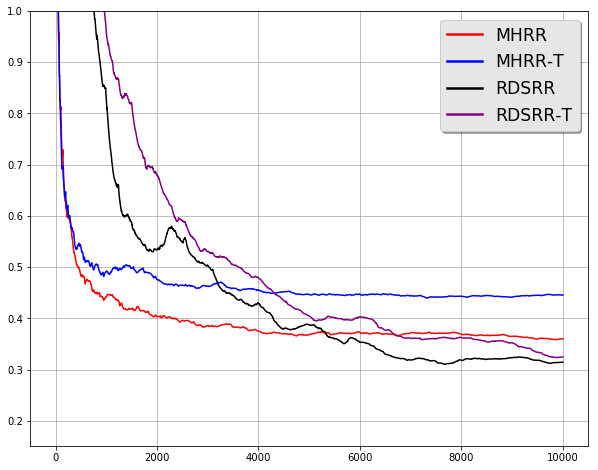

In [9]:
MSE_MH_t = 0
for ii in range(1,no_runs+1):
    MSE_MH_t += (MHRR_sampling(G,max_B)-F_org)**2
MSE_MH = MSE_MH_t/(no_runs)
MSE_MH = np.sqrt(MSE_MH)/F_org

MSE_rds_t = 0
for ii in range(1,no_runs+1):
    MSE_rds_t += (RDSRR_sampling(G,max_B)-F_org)**2
MSE_rds = MSE_rds_t/(no_runs)
MSE_rds = np.sqrt(MSE_rds)/F_org

MSE_rdsrr_t = 0
for ii in range(1,no_runs+1):
    MSE_rdsrr_t += (RDSRR_sampling(G,max_B,U)-F_org)**2
MSE_rdsrr = MSE_rdsrr_t/(no_runs)
MSE_rdsrr = np.sqrt(MSE_rdsrr)/F_org

MSE_mhrr_t = 0
for ii in range(1,no_runs+1):
    MSE_mhrr_t += (MHRR_sampling(G,max_B,U)-F_org)**2
MSE_mhrr = MSE_mhrr_t/(no_runs)
MSE_mhrr = np.sqrt(MSE_mhrr)/F_org


plt.figure(figsize=(10,8)) 
plt.plot(np.array(list(range(len(MSE_MH)))),MSE_MH,color='red',linewidth=1.5,label='MHRR')
plt.plot(np.array(list(range(len(MSE_mhrr)))),MSE_mhrr,color='blue',linewidth=1.5,label='MHRR-T')
plt.plot(np.array(list(range(len(MSE_rds)))),MSE_rds,color='black',linewidth=1.5,label='RDSRR')
plt.plot(np.array(list(range(len(MSE_rdsrr)))),MSE_rdsrr,color='purple',linewidth=1.5,label='RDSRR-T')

legend = plt.legend(loc='best', shadow=True, fontsize='xx-large')
legend.get_frame().set_facecolor('0.90')
for legobj in legend.legendHandles:
    legobj.set_linewidth(2.5)
    
plt.ylim(top=1)
plt.grid()

## F(v) = int(G.degree(node)>100)

In [10]:
def node_fn(node):
    return int(G.degree(node)>100)
F_org = sum([node_fn(i) for i in G.nodes()])/G_no_nodes
print(F_org)

0.11908888338697697


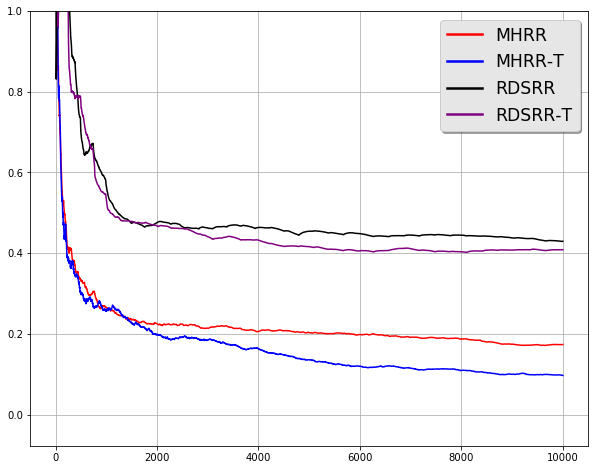

In [11]:
MSE_MH_t = 0
for ii in range(1,no_runs+1):
    MSE_MH_t += (MHRR_sampling(G,max_B)-F_org)**2
MSE_MH = MSE_MH_t/(no_runs)
MSE_MH = np.sqrt(MSE_MH)/F_org

MSE_rds_t = 0
for ii in range(1,no_runs+1):
    MSE_rds_t += (RDSRR_sampling(G,max_B)-F_org)**2
MSE_rds = MSE_rds_t/(no_runs)
MSE_rds = np.sqrt(MSE_rds)/F_org

MSE_rdsrr_t = 0
for ii in range(1,no_runs+1):
    MSE_rdsrr_t += (RDSRR_sampling(G,max_B,U)-F_org)**2
MSE_rdsrr = MSE_rdsrr_t/(no_runs)
MSE_rdsrr = np.sqrt(MSE_rdsrr)/F_org

MSE_mhrr_t = 0
for ii in range(1,no_runs+1):
    MSE_mhrr_t += (MHRR_sampling(G,max_B,U)-F_org)**2
MSE_mhrr = MSE_mhrr_t/(no_runs)
MSE_mhrr = np.sqrt(MSE_mhrr)/F_org


plt.figure(figsize=(10,8)) 
plt.plot(np.array(list(range(len(MSE_MH)))),MSE_MH,color='red',linewidth=1.5,label='MHRR')
plt.plot(np.array(list(range(len(MSE_mhrr)))),MSE_mhrr,color='blue',linewidth=1.5,label='MHRR-T')
plt.plot(np.array(list(range(len(MSE_rds)))),MSE_rds,color='black',linewidth=1.5,label='RDSRR')
plt.plot(np.array(list(range(len(MSE_rdsrr)))),MSE_rdsrr,color='purple',linewidth=1.5,label='RDSRR-T')

legend = plt.legend(loc='best', shadow=True, fontsize='xx-large')
legend.get_frame().set_facecolor('0.90')
for legobj in legend.legendHandles:
    legobj.set_linewidth(2.5)
    
plt.ylim(top=1)
plt.grid()

## F(v) = isprime(v)

In [12]:
def node_fn(node):
    return int(sympy.isprime(G.degree(node)))
F_org = sum([node_fn(i) for i in G.nodes()])/G_no_nodes
print(F_org)

0.2904184204010894


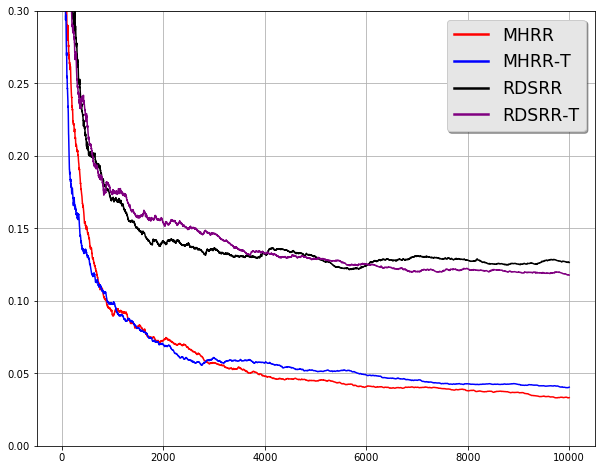

In [13]:
MSE_MH_t = 0
for ii in range(1,no_runs+1):
    MSE_MH_t += (MHRR_sampling(G,max_B)-F_org)**2
MSE_MH = MSE_MH_t/(no_runs)
MSE_MH = np.sqrt(MSE_MH)/F_org

MSE_rds_t = 0
for ii in range(1,no_runs+1):
    MSE_rds_t += (RDSRR_sampling(G,max_B)-F_org)**2
MSE_rds = MSE_rds_t/(no_runs)
MSE_rds = np.sqrt(MSE_rds)/F_org

MSE_rdsrr_t = 0
for ii in range(1,no_runs+1):
    MSE_rdsrr_t += (RDSRR_sampling(G,max_B,U)-F_org)**2
MSE_rdsrr = MSE_rdsrr_t/(no_runs)
MSE_rdsrr = np.sqrt(MSE_rdsrr)/F_org

MSE_mhrr_t = 0
for ii in range(1,no_runs+1):
    MSE_mhrr_t += (MHRR_sampling(G,max_B,U)-F_org)**2
MSE_mhrr = MSE_mhrr_t/(no_runs)
MSE_mhrr = np.sqrt(MSE_mhrr)/F_org


plt.figure(figsize=(10,8)) 
plt.plot(np.array(list(range(len(MSE_MH)))),MSE_MH,color='red',linewidth=1.5,label='MHRR')
plt.plot(np.array(list(range(len(MSE_mhrr)))),MSE_mhrr,color='blue',linewidth=1.5,label='MHRR-T')
plt.plot(np.array(list(range(len(MSE_rds)))),MSE_rds,color='black',linewidth=1.5,label='RDSRR')
plt.plot(np.array(list(range(len(MSE_rdsrr)))),MSE_rdsrr,color='purple',linewidth=1.5,label='RDSRR-T')
plt.ylim(0,0.3)

legend = plt.legend(loc='best', shadow=True, fontsize='xx-large')
legend.get_frame().set_facecolor('0.90')
for legobj in legend.legendHandles:
    legobj.set_linewidth(2.5)
    
plt.grid()

## F(v) = random

In [14]:
fn_mapping = np.random.exponential(1,size=(G_no_nodes))
def node_fn(node):
    return fn_mapping[node]

F_org = sum([node_fn(i) for i in G.nodes()])/G_no_nodes
print(F_org)    

0.9856442941970124


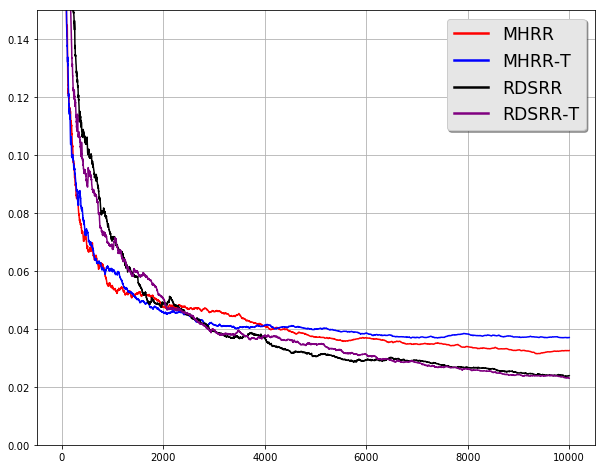

In [15]:
MSE_MH_t = 0
for ii in range(1,no_runs+1):
    MSE_MH_t += (MHRR_sampling(G,max_B)-F_org)**2
MSE_MH = MSE_MH_t/(no_runs)
MSE_MH = np.sqrt(MSE_MH)/F_org

MSE_rds_t = 0
for ii in range(1,no_runs+1):
    MSE_rds_t += (RDSRR_sampling(G,max_B)-F_org)**2
MSE_rds = MSE_rds_t/(no_runs)
MSE_rds = np.sqrt(MSE_rds)/F_org

MSE_rdsrr_t = 0
for ii in range(1,no_runs+1):
    MSE_rdsrr_t += (RDSRR_sampling(G,max_B,U)-F_org)**2
MSE_rdsrr = MSE_rdsrr_t/(no_runs)
MSE_rdsrr = np.sqrt(MSE_rdsrr)/F_org

MSE_mhrr_t = 0
for ii in range(1,no_runs+1):
    MSE_mhrr_t += (MHRR_sampling(G,max_B,U)-F_org)**2
MSE_mhrr = MSE_mhrr_t/(no_runs)
MSE_mhrr = np.sqrt(MSE_mhrr)/F_org


plt.figure(figsize=(10,8)) 
plt.plot(np.array(list(range(len(MSE_MH)))),MSE_MH,color='red',linewidth=1.5,label='MHRR')
plt.plot(np.array(list(range(len(MSE_mhrr)))),MSE_mhrr,color='blue',linewidth=1.5,label='MHRR-T')
plt.plot(np.array(list(range(len(MSE_rds)))),MSE_rds,color='black',linewidth=1.5,label='RDSRR')
plt.plot(np.array(list(range(len(MSE_rdsrr)))),MSE_rdsrr,color='purple',linewidth=1.5,label='RDSRR-T')

legend = plt.legend(loc='best', shadow=True, fontsize='xx-large')
legend.get_frame().set_facecolor('0.90')
for legobj in legend.legendHandles:
    legobj.set_linewidth(2.5)
    
plt.ylim(0,0.15)
plt.grid()